<a href="https://colab.research.google.com/github/ballmdr/Forex-Prediction-Machine_Learning/blob/master/VAE_Tensorflow_2_0_in_Pytorch_styles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0-rc0 

     |████████████████████████████████| 86.3MB 518kB/s 
     |████████████████████████████████| 501kB 23.7MB/s 
     |████████████████████████████████| 4.3MB 18.8MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-rc0


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1, np.prod(x_train.shape[1:])).astype(np.float32)
x_test = x_test.reshape(-1, np.prod(x_test.shape[1:])).astype(np.float32)

print(x_train.shape)
print(x_test.shape)
print(x_train.max())
print(x_train.min())

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)
1.0
0.0


In [0]:
class VAE(tf.keras.Model):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder1 = tf.keras.layers.Dense(500)
        self.encoder2 = tf.keras.layers.Dense(250)
        self.encoder3 = tf.keras.layers.Dense(100)

        self.latent = tf.keras.layers.Dense(50)

        self.decoder1 = tf.keras.layers.Dense(100)
        self.decoder2 = tf.keras.layers.Dense(250)
        self.decoder3 = tf.keras.layers.Dense(500)

        self.output_layer = tf.keras.layers.Dense(784)

    def call(self, x):
        x = self.encode(x)

        means = self.latent(x)
        std = tf.nn.softplus(self.latent(x)) + 1e-6
        #tf.print(means)
        z_latent = means + tf.math.exp(0.5 * std) * tfd.Normal(loc=means, scale=std).sample()

        x = self.decode(z_latent)

        logit = self.output_layer(x)
        pred = tf.nn.sigmoid(logit)

        kl_loss = 1 + std - tf.math.square(means) - tf.math.exp(std)
        kl_loss = tf.math.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        return logit, pred, kl_loss
    
    def encode(self, x):
        x = tf.nn.relu(self.encoder1(x))
        x = tf.nn.relu(self.encoder2(x))
        x = tf.nn.relu(self.encoder3(x))
        return x

    def decode(self, x):
        x = tf.nn.relu(self.decoder1(x))
        x = tf.nn.relu(self.decoder2(x))
        x = tf.nn.relu(self.decoder3(x))
        return x

In [0]:
model = VAE()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
batch_size = 1000
epochs = 1000
train_loss = tf.keras.metrics.Mean(name='train loss')
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logit, predictions, kl_loss = model(images)
        #tf.print(predictions)
        #tf.print(kl_loss)
        log_l = tf.keras.losses.binary_crossentropy(images, predictions) * x_train.shape[1]
        #tf.print(log_l)
        vae_loss = tf.math.reduce_mean(log_l + kl_loss)
        #tf.print(vae_loss)
    gradients = tape.gradient(vae_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(vae_loss)

In [0]:
for e in range(epochs):
    for x_batch, y_batch in train_ds:
        train_step(x_batch, y_batch)

    if e % 1 == 0:
        print(e+1, ' loss: ', train_loss.result())

    train_loss.reset_states()

1  loss:  tf.Tensor(93.95542, shape=(), dtype=float32)
2  loss:  tf.Tensor(93.97105, shape=(), dtype=float32)
3  loss:  tf.Tensor(93.89526, shape=(), dtype=float32)
4  loss:  tf.Tensor(93.73122, shape=(), dtype=float32)
5  loss:  tf.Tensor(93.64954, shape=(), dtype=float32)
6  loss:  tf.Tensor(93.63013, shape=(), dtype=float32)
7  loss:  tf.Tensor(93.59626, shape=(), dtype=float32)
8  loss:  tf.Tensor(93.433014, shape=(), dtype=float32)
9  loss:  tf.Tensor(93.390816, shape=(), dtype=float32)
10  loss:  tf.Tensor(93.253525, shape=(), dtype=float32)
11  loss:  tf.Tensor(93.228424, shape=(), dtype=float32)
12  loss:  tf.Tensor(93.20548, shape=(), dtype=float32)
13  loss:  tf.Tensor(93.15315, shape=(), dtype=float32)
14  loss:  tf.Tensor(93.16966, shape=(), dtype=float32)
15  loss:  tf.Tensor(93.15657, shape=(), dtype=float32)
16  loss:  tf.Tensor(93.147865, shape=(), dtype=float32)
17  loss:  tf.Tensor(92.98693, shape=(), dtype=float32)
18  loss:  tf.Tensor(92.99797, shape=(), dtype=float

In [0]:
weights = model.get_weights()

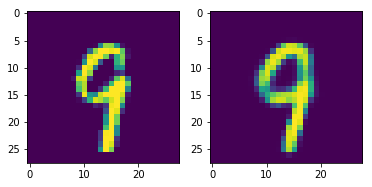

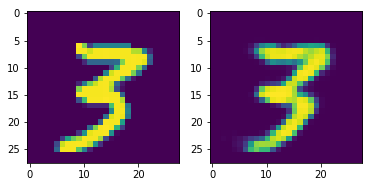

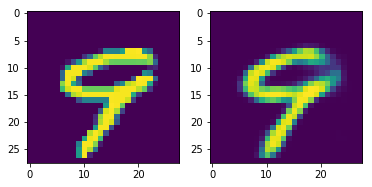

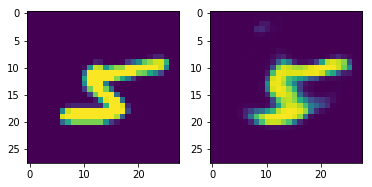

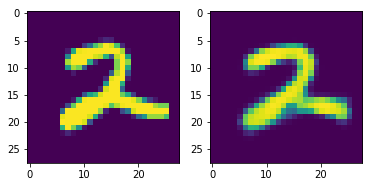

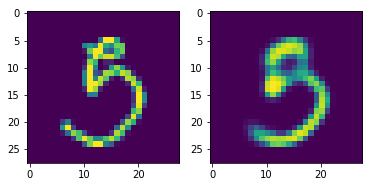

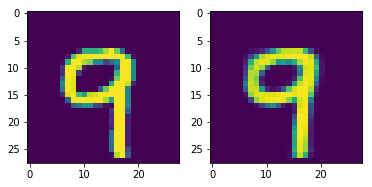

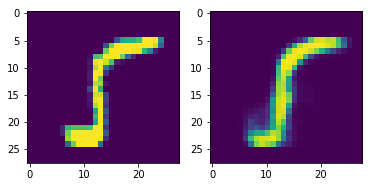

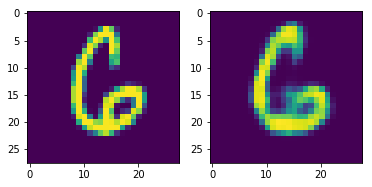

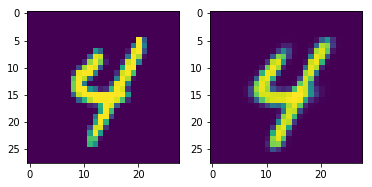

In [20]:
for i in range(10):
    idx = np.random.randint(0, len(x_test)-1)
    logit, y_pred, kl_loss = model(x_test[idx].reshape(1, -1))
    fix, ax = plt.subplots(1, 2)
    ax[0].imshow(x_test[idx].reshape(28,28) * 255.0)
    ax[1].imshow(y_pred.numpy().reshape(28,28) * 255.0)
    plt.show()